<a href="https://colab.research.google.com/github/Adrian-Muino/DMML2022_Geneva/blob/main/Code/1.DMML_2022_Geneva_Mandatory_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A. Introduction

## Group project for Data Mining & Machine Learning course, at HEC UNIL 2022 (Geneva Group)
This notebook is the starting point of our journey for the competition in kaggle
[Detecting the difficulty level of French texts](https://www.kaggle.com/competitions/detecting-french-texts-difficulty-level-2022)

You can find all our work in the following [GitHub](https://github.com/Adrian-Muino/DMML2022_Geneva).

In this notebook, we will try differents classification models that were mandatory to do without text cleaning. This will allow us to have a baseline, to make some exploratory data analysis and to compare these basic models among them.


>[A. Introduction](#scrollTo=WjM8oPFaJUaQ)

>>[Group project for Data Mining & Machine Learning course, at HEC UNIL 2022 (Geneva Group)](#scrollTo=GlMcpYt9JhdJ)

>[B. Prerequisites](#scrollTo=IwbhYkX9PwKK)

>>[Installations](#scrollTo=LRWqteO2JQh1)

>>[Imports](#scrollTo=cA-qKTd6Jdjk)

>[C. Exploratory data analysis](#scrollTo=tVZA1QQ1Qjpr)

>>[Loading the data](#scrollTo=ud2AKXGMKEPQ)

>>[Basic computations](#scrollTo=Dt32LbydQ7D9)

>>[Baseline](#scrollTo=Uj7fHC0VHsMx)

>[D. Mandatory Models](#scrollTo=_czoye1NR1MH)

>>[Logistic Regression](#scrollTo=xtOTivyrH6YE)

>>[K-nearest neighbors algorithm](#scrollTo=YXohCuY5JNx-)

>>[Decision tree](#scrollTo=Hgv_4WAVJhiR)

>>[Random Forest](#scrollTo=Rc8iA3U1KD_2)

>[E. Mandatory Models comparison](#scrollTo=50ghX0OrX1l-)



#B. Prerequisites

##Installations

In [ ]:
#Installation
!pip install sentence-transformers
!python -m spacy download fr_core_news_sm
!python -m spacy link fr_core_news_sm fr
!python -m spacy download fr_core_news_md
!pip install tensorflow_hub
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 5.8 MB 60.4 MB/s 
     |████████████████████████████████| 1.3 MB 65.0 MB/s 
     |████████████████████████████████| 182 kB 76.5 MB/s 
     |████████████████████████████████| 7.6 MB 53.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=7c3145feaa40e9a7b856aa3e3216a3cc904b93b78414867be44695de5b257afb
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 29.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ As of spaCy v3.0, mode

##Imports

In [ ]:
# Imports the functions we use all along our projects that are in python file in our GitHub
import requests
url = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Code/dmml_2022_geneva_functions.py'

r = requests.get(url)

with open('dmml_2022_geneva_functions.py', 'w') as f:
    f.write(r.text)

In [ ]:
# All the other imports
import string
import re
from dmml_2022_geneva_functions import *
import pandas as pd

import spacy
from spacy import displacy

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
nltk.download('punkt')

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, Perceptron
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.multiclass import unique_labels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#C. Exploratory data analysis

##Loading the data

In [ ]:
# load the data from our github repository
training_data = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Data/training_data.csv'
unlabelled_data = 'https://raw.githubusercontent.com/Adrian-Muino/DMML2022_Geneva/main/Data/unlabelled_test_data.csv'

df = df_train = pd.read_csv(training_data)
df_unlabeled = df_test = pd.read_csv(unlabelled_data)


In [ ]:
df.head()

,id,sentence,difficulty
0,0,Les coûts kilométriques réels peuvent diverger...,C1
1,1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,2,Le test de niveau en français est sur le site ...,A1
3,3,Est-ce que ton mari est aussi de Boston?,A1
4,4,"Dans les écoles de commerce, dans les couloirs...",B1


In [ ]:
df_unlabeled.head()

,id,sentence
0,0,Nous dûmes nous excuser des propos que nous eû...
1,1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,2,"Et, paradoxalement, boire froid n'est pas la b..."
3,3,"Ce n'est pas étonnant, car c'est une saison my..."
4,4,"Le corps de Golo lui-même, d'une essence aussi..."


##Basic computations

Value counts for each difficulty category in the dataset

In [ ]:
# How many sentences of each category
df_train['difficulty'].value_counts()

A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

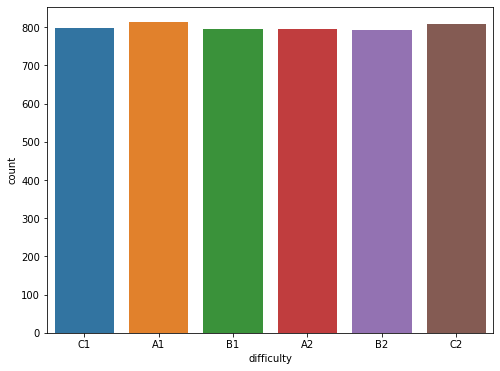

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x=df_train.difficulty)
plt.show()

Number of Word/Punctation vs difficulty

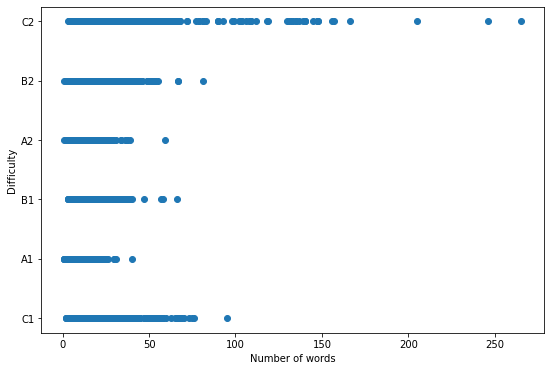

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9,6))

# split on space (keeps punctations)
nbWords = [len(sent.split(" ")) for sent in df_train.sentence]
difficulties = [dif for dif in df_train.difficulty]

ax.set_xlabel("Number of words")
ax.set_ylabel("Difficulty")

ax.scatter(nbWords, difficulties)

## Baseline

In [ ]:
# Base line calculation
difficulty_A1_count = df.loc[df["difficulty"] == "A1"].shape[0]
difficulty_A2_count = df.loc[df["difficulty"] == "A2"].shape[0]
difficulty_B1_count = df.loc[df["difficulty"] == "B1"].shape[0]
difficulty_B2_count = df.loc[df["difficulty"] == "B2"].shape[0]
difficulty_C1_count = df.loc[df["difficulty"] == "C1"].shape[0]
difficulty_C2_count = df.loc[df["difficulty"] == "C2"].shape[0]
baserate = max(difficulty_A1_count, difficulty_A2_count,difficulty_B1_count,difficulty_B2_count,difficulty_C1_count,difficulty_C2_count)/(df["difficulty"].shape[0])
print("Baserate = ", baserate)

Baserate =  0.169375


#D. Mandatory Models

In [ ]:
tfidf_vector = TfidfVectorizer()

## Logistic Regression

Logistic regression is a statistical method used to model the relationship between a dependent variable and one or more independent variables when the dependent variable is binary, or can take only two values (e.g., 0 or 1, true or false). It is used to predict a binary response, such as whether an event will occur or not.

In [ ]:
X = df["sentence"] # the features we want to analyze
y = df["difficulty"] # the labels we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


In [ ]:
# Define classifier
LR_model= LogisticRegression(solver = "lbfgs", random_state=0)

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
LR_pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', LR_model)])

# Fit model on training set & predict
LR_pipe.fit(X_train, y_train)

LR_pred = LR_pipe.predict(X_test)

LR_pred_report = evaluate(y_test, LR_pred)

# Storing the model performance results in a DF called reports
reports['Logistic Regression'] = LR_pred_report

pd.DataFrame(LR_pred_report, index = ['LR_report'])

,accuracy,recall,precision,f1_score
LR_report,0.466667,0.467678,0.464496,0.464014


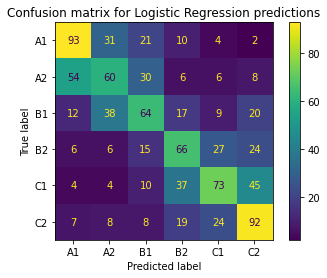

In [ ]:
#function imported
plot_confusion_matrix(y_test, LR_pred, LR_pipe)
plt.title('Confusion matrix for Logistic Regression predictions')
plt.show()

##K-nearest neighbors algorithm

The K-nearest neighbors (KNN) algorithm is a non-parametric method used for classification and regression. In both cases, the goal is to predict the value of a target variable for a given data point by looking at the values of the target variable for the K nearest data points.

For classification, the target variable is a categorical variable with a fixed set of possible values, and the KNN algorithm assigns the data point to the most common category among its K nearest neighbors. For regression, the target variable is a continuous variable, and the KNN algorithm predicts the value of the target variable for the data point as the average of the values of the K nearest neighbors.

Grid search is a method used to tune the hyperparameters of a machine learning model. It involves training the model with a range of different hyperparameter values and evaluating the performance of each set of hyperparameters using a validation set. The goal is to find the combination of hyperparameters that results in the best performance on the validation set.
  

In [ ]:
# This GridSearch takes a long time to execute, if you don't want to wait too long you can comment it and set the following parameters in the next code {'n_neighbors': 63, 'p': 2, 'weights': 'distance'}
# Define classifier
knn_model = KNeighborsClassifier()
Nknn = list(range(1, 100))
param_grid = {'n_neighbors':np.arange(1,100),'p':np.arange(1,3),'weights':['uniform','distance']}

# Create pipeline
## The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.
knn_grid = GridSearchCV(knn_model, param_grid, cv=5, return_train_score=False,verbose=1)
knn_pipe = Pipeline([('vectorizer',  tfidf_vector), ('classifier', knn_grid)])

# Fit model on training set
knn_pipe.fit(X_train, y_train)

best_param_knn_neighbor = knn_grid .best_params_.get('n_neighbors')
best_param_knn_p = knn_grid .best_params_.get('p')
best_param_knn_weights = knn_grid .best_params_.get('weights')
print(knn_grid .best_params_)

Fitting 5 folds for each of 396 candidates, totalling 1980 fits
{'n_neighbors': 63, 'p': 2, 'weights': 'distance'}


In [ ]:
# Define classifier using the best parameter "best_param_knn" from above
knn_classifier = KNeighborsClassifier(n_neighbors = best_param_knn_neighbor, p = best_param_knn_p, weights = best_param_knn_weights)

# Create pipeline
KNN_pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', knn_classifier)])

# Fit model on training set & predict
KNN_pipe.fit(X_train, y_train)

KNN_pred = KNN_pipe.predict(X_test)

KNN_pred_report = evaluate(y_test, KNN_pred)

# Storing the model performance results in a DF called reports
reports['K-nearest neighbors'] = KNN_pred_report

pd.DataFrame(KNN_pred_report, index = ['KNN_report'])

,accuracy,recall,precision,f1_score
KNN_report,0.360417,0.361603,0.385899,0.336087


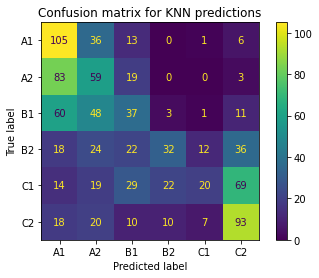

In [ ]:
#function imported
plot_confusion_matrix(y_test, KNN_pred, KNN_pipe)
plt.title('Confusion matrix for KNN predictions')
plt.show()

##Decision tree

A decision tree is a tree-like model used for classification and regression tasks. It is a type of supervised learning algorithm that is based on the idea of dividing the input space into regions based on the value of certain features, with the goal of achieving high accuracy in classifying or predicting the target variable.

In [ ]:
# Define classifier
tree_model = DecisionTreeClassifier()

# Create pipeline
tree_pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', tree_model)])

# Fit model on training set & predict
tree_pipe.fit(X_train, y_train)

tree_pred = tree_pipe.predict(X_test)

tree_pred_report = evaluate(y_test, tree_pred)

# Storing the model performance results in a DF called reports
reports['Decision Tree'] = tree_pred_report

pd.DataFrame(tree_pred_report, index = ['Tree_report'])


,accuracy,recall,precision,f1_score
Tree_report,0.3,0.29991,0.29892,0.296415


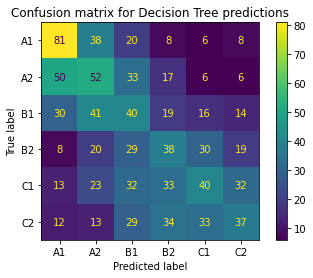

In [ ]:
#function imported
plot_confusion_matrix(y_test, tree_pred, tree_pipe)
plt.title('Confusion matrix for Decision Tree predictions')
plt.show()

##Random Forest

 Random forest is an ensemble learning method for classification and regression tasks. It is a type of supervised learning algorithm that uses multiple decision trees and combines their predictions to make a final prediction.

In [ ]:
# Define classifier
forest_model = RandomForestClassifier()

# Create pipeline
forest_pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', forest_model)])

# Fit model on training set & predict
forest_pipe.fit(X_train, y_train)

forest_pred = forest_pipe.predict(X_test)

forest_pred_report = evaluate(y_test, forest_pred)

# Storing the model performance results in a DF called reports
reports['Random Forest'] = forest_pred_report

pd.DataFrame(forest_pred_report, index = ['Random Forest'])

,accuracy,recall,precision,f1_score
Random Forest,0.415625,0.417837,0.42676,0.405985


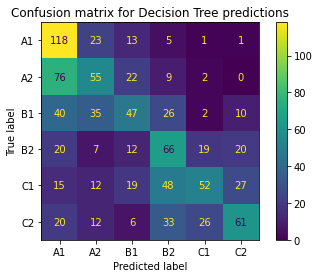

In [ ]:
#function imported
plot_confusion_matrix(y_test, forest_pred, forest_pipe)
plt.title('Confusion matrix for Decision Tree predictions')
plt.show()

#E. Mandatory Models comparison

Here after, we can see that logistic regression model has a better accuracy compared to the other ones.

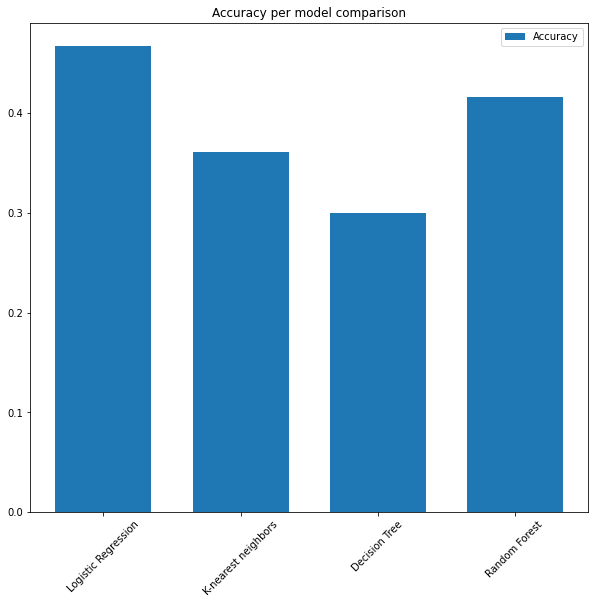

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,9))

width = 0.70
labels = reports.keys()
report_values_accuracy = [x['accuracy'] for x in reports.values()]

ax.bar(labels, report_values_accuracy, 
        label='Accuracy', width=width)
plt.title("Accuracy per model comparison")
plt.xticks(rotation=45)
ax.legend()

In [ ]:
pd.DataFrame(reports, index = ['accuracy','recall','precision','f1_score']).T.sort_values(by='accuracy', ascending=False).T

,Logistic Regression,Random Forest,K-nearest neighbors,Decision Tree
accuracy,0.466667,0.415625,0.360417,0.300000
recall,0.467678,0.417837,0.361603,0.299910
precision,0.464496,0.426760,0.385899,0.298920
f1_score,0.464014,0.405985,0.336087,0.296415
